In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyvi import ViTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from collections import Counter
from tabulate import tabulate
import base64
from io import BytesIO
import re
import nltk
from nltk.corpus import stopwords

In [2]:
# Tải stopword (cần chạy lần đầu)
nltk.download('stopwords')

# Thiết lập phong cách cho biểu đồ
sns.set(style='whitegrid', palette='deep')

# Đọc dữ liệu từ tệp CSV
df = pd.read_csv('cleaned_comment_data.csv')

# Loại bỏ trùng lặp dựa trên cột content
df = df.drop_duplicates(subset=['content'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\huanc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Danh sách stopword tiếng Việt mở rộng
vietnamese_stopwords = {
    'là', 'và', 'của', 'trong', 'được', 'thì', 'này', 'đó', 'rất', 'quá', 'như', 
    'cho', 'với', 'tại', 'một', 'các', 'có', 'không', 'để', 'tôi', 'mình', 'bạn', 
    'hàng', 'sp', 'sản_phẩm', 'nên', 'nhưng', 'vì', 'nếu', 'khi', 'lại', 'đã', 'còn'
}

In [ ]:

# Tiền xử lý văn bản tiếng Việt
def preprocess_text(text):
    if pd.isna(text):
        return ""
    # Chuyển thành chữ thường, loại bỏ ký tự đặc biệt
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    # Tách từ bằng pyvi
    text = ViTokenizer.tokenize(text)
    # Loại bỏ stopword
    stop_words = set(stopwords.words('english')).union(vietnamese_stopwords)
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# Áp dụng tiền xử lý
if 'content' in df.columns:
    df['processed_content'] = df['content'].apply(preprocess_text)
else:
    print("Lỗi: Cột 'content' không tồn tại trong DataFrame.")
    exit()

print(df.info())

print(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 4474 entries, 0 to 9565
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              4474 non-null   object 
 1   content            4473 non-null   object 
 2   customer_id        4474 non-null   int64  
 3   rating             4474 non-null   int64  
 4   created_at         4474 non-null   int64  
 5   customer_name      4471 non-null   object 
 6   purchased_at       4473 non-null   float64
 7   processed_content  4474 non-null   object 
dtypes: float64(1), int64(3), object(4)
memory usage: 314.6+ KB
None
                title                                            content  \
0     Cực kì hài lòng  Sản phẩm được giao nhanh chóng, kỹ lưỡng. Cây ...   
1  Rất không hài lòng  Cây lau nhà lỗi ko thể dùng được. Lắp vào ko q...   
2  Rất không hài lòng  Hàng méo cong vênh, chốt xoay gãy, mỏng yếu, y...   
3     Cực kì hài lòng                         

In [5]:
# Chuyển các cột có kiểu 'object' thành 'string'
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype('string')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4474 entries, 0 to 9565
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              4474 non-null   string 
 1   content            4473 non-null   string 
 2   customer_id        4474 non-null   int64  
 3   rating             4474 non-null   int64  
 4   created_at         4474 non-null   int64  
 5   customer_name      4471 non-null   string 
 6   purchased_at       4473 non-null   float64
 7   processed_content  4474 non-null   string 
dtypes: float64(1), int64(3), string(4)
memory usage: 314.6 KB
None


In [6]:
# Loại bỏ các hàng có nội dung rỗng sau khi xử lý
df = df[df['processed_content'] != ''].dropna(subset=['processed_content'])

print(df.columns)

# Tạo cột sentiment dựa trên rating
def map_sentiment(rating):
    if rating >= 4:
        return 'Tích cực'
    elif rating == 3:
        return 'Trung tính'
    else:
        return 'Tiêu cực'

df['sentiment'] = df['rating'].apply(map_sentiment)

# Trích xuất đặc trưng bằng TF-IDF
tfidf = TfidfVectorizer(max_features=10000)
X = tfidf.fit_transform(df['processed_content'])
y = df['sentiment']

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Index(['title', 'content', 'customer_id', 'rating', 'created_at',
       'customer_name', 'purchased_at', 'processed_content'],
      dtype='object')


In [7]:
# Huấn luyện và đánh giá mô hình Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_y_pred = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_y_pred)
lr_precision, lr_recall, lr_f1, _ = precision_recall_fscore_support(y_test, lr_y_pred, average='weighted')
lr_cm = confusion_matrix(y_test, lr_y_pred, labels=['Tích cực', 'Trung tính', 'Tiêu cực'])

In [8]:
# Huấn luyện và đánh giá mô hình SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
svm_y_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_y_pred)
svm_precision, svm_recall, svm_f1, _ = precision_recall_fscore_support(y_test, svm_y_pred, average='weighted')
svm_cm = confusion_matrix(y_test, svm_y_pred, labels=['Tích cực', 'Trung tính', 'Tiêu cực'])

c:\Users\huanc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:

# Hàm lưu biểu đồ thành base64
def save_plot_to_base64():
    buffer = BytesIO()
    plt.savefig(buffer, format='png', bbox_inches='tight')
    buffer.seek(0)
    img_str = base64.b64encode(buffer.getvalue()).decode()
    buffer.close()
    return img_str


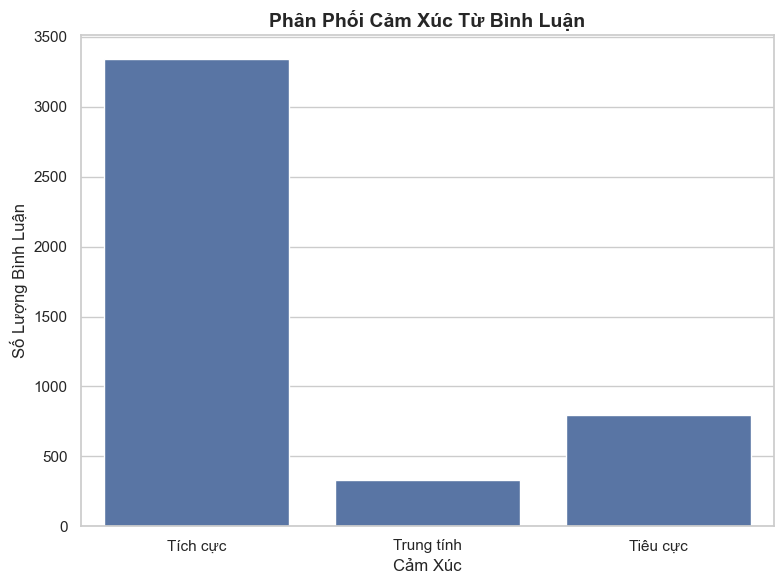

In [10]:
# Biểu đồ phân phối cảm xúc
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df, order=['Tích cực', 'Trung tính', 'Tiêu cực'])
plt.title('Phân Phối Cảm Xúc Từ Bình Luận', fontsize=14, fontweight='bold')
plt.xlabel('Cảm Xúc', fontsize=12)
plt.ylabel('Số Lượng Bình Luận', fontsize=12)
plt.tight_layout()
sentiment_dist_plot = save_plot_to_base64()

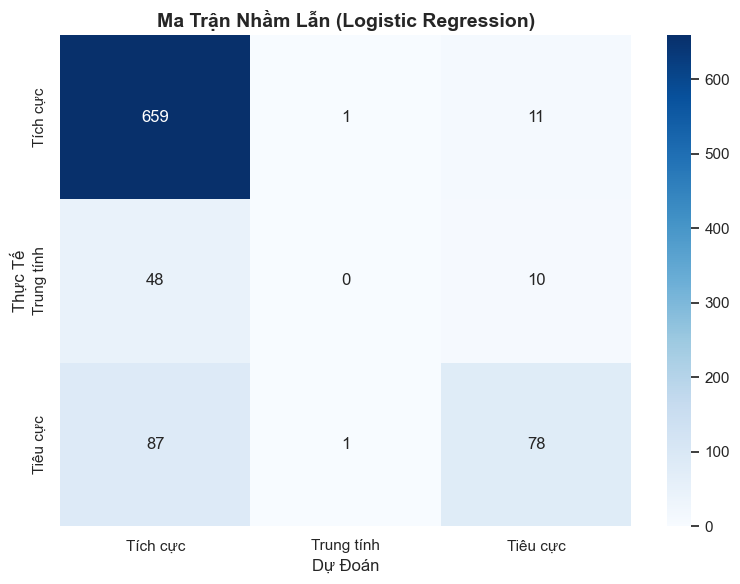

In [11]:
# Biểu đồ ma trận nhầm lẫn cho Logistic Regression
plt.figure(figsize=(8, 6))
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Tích cực', 'Trung tính', 'Tiêu cực'], 
            yticklabels=['Tích cực', 'Trung tính', 'Tiêu cực'])
plt.title('Ma Trận Nhầm Lẫn (Logistic Regression)', fontsize=14, fontweight='bold')
plt.xlabel('Dự Đoán', fontsize=12)
plt.ylabel('Thực Tế', fontsize=12)
plt.tight_layout()
lr_confusion_matrix_plot = save_plot_to_base64()

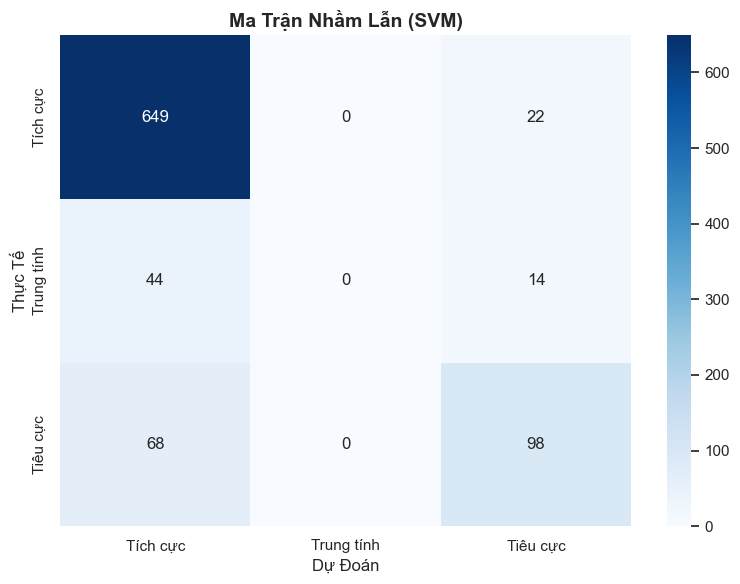

In [12]:
# Biểu đồ ma trận nhầm lẫn cho SVM
plt.figure(figsize=(8, 6))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Tích cực', 'Trung tính', 'Tiêu cực'], 
            yticklabels=['Tích cực', 'Trung tính', 'Tiêu cực'])
plt.title('Ma Trận Nhầm Lẫn (SVM)', fontsize=14, fontweight='bold')
plt.xlabel('Dự Đoán', fontsize=12)
plt.ylabel('Thực Tế', fontsize=12)
plt.tight_layout()
svm_confusion_matrix_plot = save_plot_to_base64()

In [13]:
# Trích xuất từ khóa phổ biến
def get_top_keywords(sentiment, n=10):
    texts = df[df['sentiment'] == sentiment]['processed_content'].str.split()
    words = [word for text in texts for word in text]
    word_counts = Counter(words)
    return word_counts.most_common(n)

positive_keywords = get_top_keywords('Tích cực')
negative_keywords = get_top_keywords('Tiêu cực')

# Tạo bảng so sánh hiệu suất mô hình
performance_table = [
    ['Logistic Regression', f'{lr_accuracy:.2f}', f'{lr_precision:.2f}', f'{lr_recall:.2f}', f'{lr_f1:.2f}'],
    ['SVM', f'{svm_accuracy:.2f}', f'{svm_precision:.2f}', f'{svm_recall:.2f}', f'{svm_f1:.2f}']
]
performance_html = tabulate(performance_table, headers=['Mô Hình', 'Accuracy', 'Precision', 'Recall', 'F1-Score'], tablefmt='html')

# Tạo bảng từ khóa phổ biến
keywords_table = [
    ['Tích cực', ', '.join([f'{word} ({count})' for word, count in positive_keywords])],
    ['Tiêu cực', ', '.join([f'{word} ({count})' for word, count in negative_keywords])]
]
keywords_html = tabulate(keywords_table, headers=['Cảm Xúc', 'Từ Khóa Phổ Biến'], tablefmt='html')

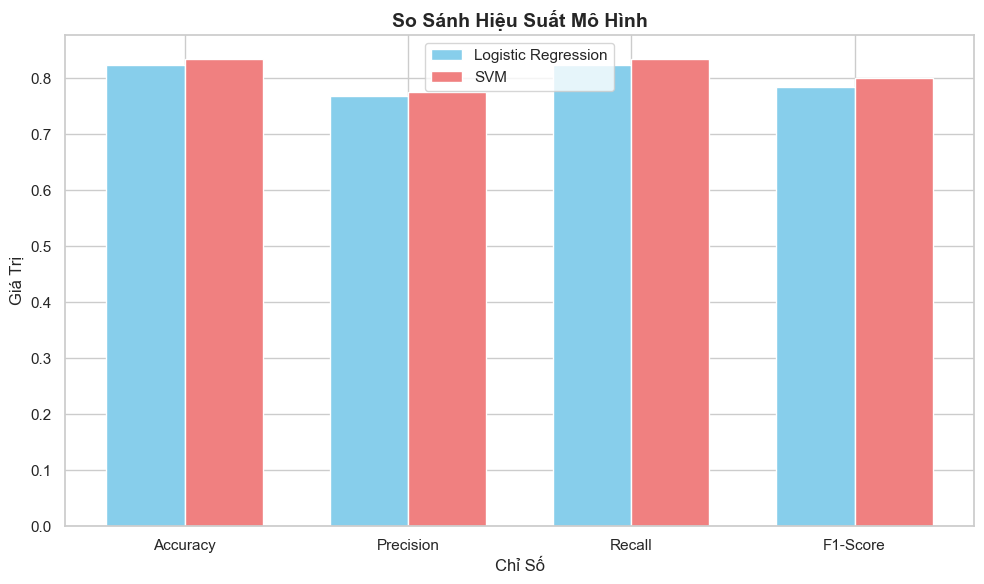

In [14]:
# Dữ liệu hiệu suất mô hình
models = ['Logistic Regression', 'SVM']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
performance_data = {
    'Logistic Regression': [lr_accuracy, lr_precision, lr_recall, lr_f1],
    'SVM': [svm_accuracy, svm_precision, svm_recall, svm_f1]
}

# Tạo biểu đồ cột
x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, performance_data['Logistic Regression'], width, label='Logistic Regression', color='skyblue')
plt.bar(x + width/2, performance_data['SVM'], width, label='SVM', color='lightcoral')
plt.xlabel('Chỉ Số', fontsize=12)
plt.ylabel('Giá Trị', fontsize=12)
plt.title('So Sánh Hiệu Suất Mô Hình', fontsize=14, fontweight='bold')
plt.xticks(x, metrics)
plt.legend()
plt.tight_layout()
model_performance_plot = save_plot_to_base64()